# Temporal analysis of Shrinking of RBCs from unstained RBC videos

## Soham Sawant - 211057017(AIML)

## IMPORTING LIBRARIES

In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import keras.backend as K

## DATA SECTION

**The Dataset is Collected from KMC Physiology Department,it contains the videos of RBCs stressed with:**

1.   UREA
2.   NACL
3.   SUCROSE

* The purpose of applying these stress agents is to do temporal analysis ,basically observing reactions on normal blood cells when foreign bodies from some disease are interacting with it,they use this process for manufacturing and producing drugs for medicinal use







###  Converting Video to Individual Images with the Use of Open Cv library



In [ ]:
import cv2
vidcap = cv2.VideoCapture('/content/drive/MyDrive/study material/Colab Notebooks/SEM 2/CNN/Datasets/DATA/UREA/20180420_145328.mp4')
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("image"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames
sec = 0
frameRate = 10.0 #//it will capture image in each 10 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

### Data Processing Part After Annotations

* Around 100 image I have annotated using label me for my experimentation which were from UREA stress , with approx of 150-200 cells in those 100 annotated images

* After Annotating each image we get it into json format , by the function below we converted to png file so we can pass it to the network

* The following function will create single folder which will contain the ground truth , original image and other metadata

* The ground truth will be in RGB format , but while pre-process stage we will read it in grayscale format while passing to the model for training

* The overview of generated folder:
 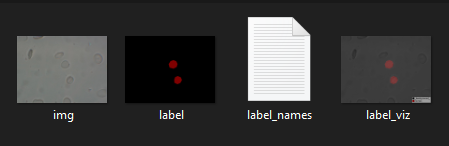


In [ ]:
import labelme

#Function to convert annotation json file to images
def labelme_json_to_dataset(json_path):
    os.system("labelme_json_to_dataset "+json_path+" -o "+json_path.replace(".","_"))

#Convert all the json files using for loop
start_index = 0
end_index = 103
try:
    print('Running.........')
    for i in range(start_index,end_index+1):
        json_file = 'img(' +str(i)+ ').json'
        path = "F:/2_SEM/CNN/pro/DATA/ANNOTATED/" +  json_file
        labelme_json_to_dataset(path)
        print(json_file)
    print('Task Completed!!!')
except:
    print('Error Occured!!!')

### Data Pre-Processing before fitting to model
* Here we are scaling the images to 128,128,3 as the generated images and mask are having sizes around 1280x960 , this makes the calculation little less complex as the number of pixels will reduce and it will train faster.

* Here the code below will iterate over the files and resize all the images and store in into X_train ,Y_train an X_test variables which we are initializing to zeros.



In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/study_material/Colab Notebooks/SEM 2/CNN/Datasets/DATA/generated/'
TEST_PATH = '/content/drive/MyDrive/study_material/Colab Notebooks/SEM 2/CNN/Datasets/DATA/TEST/'

In [ ]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[2]

In [ ]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
#Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

In [ ]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = TRAIN_PATH + id_
  img = imread(path + '/img.png')[:,:,:IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_train[n] = img #Fill empty X_train with values from img
  mask = imread(path + '/label.png')[:,:,:1]
  mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  Y_train[n] = mask

Resizing training images and masks


100%|██████████| 93/93 [00:56<00:00,  1.66it/s]


In [ ]:
# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!') 

Resizing test images


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]

Done!


### Sample X-train and Y-train

15


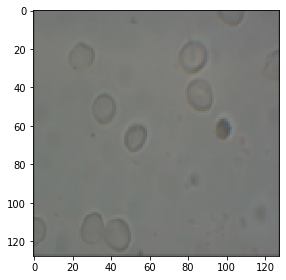

(128, 128, 1)


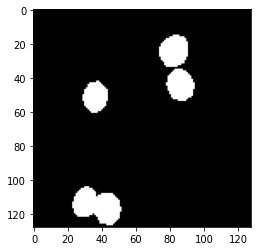

In [ ]:
image_x = random.randint(0, len(train_ids)-1)
print(image_x)
imshow(X_train[image_x])
plt.show()
Y_train_img = Y_train[image_x].astype(np.uint8)  
Y_train_img*=255
print(Y_train_img.shape) 
plt.imshow(np.squeeze(Y_train_img),cmap='gray')
plt.show()


## **BASE UNET MODEL**
* This is the first trial with parameters:
  - learning rate = 0.0001
  - batch size = 8
  - epoch = 25
  - loss = binary cross-entropy
  - train split = 0.8
  - validation split = 0.1
  - test split = 0.1

  
  

In [ ]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model_unet_original = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_unet_original.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model_unet_original.summary()

In [ ]:
results_unet = model_unet_original.fit(X_train, Y_train, validation_split=0.2, batch_size=8, epochs=25)

Epoch 1/25
10/10 [==============================] - 16s 172ms/step - loss: 1.0095 - accuracy: 0.0572 - val_loss: 0.8908 - val_accuracy: 0.0731
Epoch 2/25
10/10 [==============================] - 0s 26ms/step - loss: 0.8346 - accuracy: 0.1226 - val_loss: 0.7376 - val_accuracy: 0.1652
Epoch 3/25
10/10 [==============================] - 0s 26ms/step - loss: 0.6808 - accuracy: 0.5363 - val_loss: 0.5937 - val_accuracy: 0.8765
Epoch 4/25
10/10 [==============================] - 0s 27ms/step - loss: 0.3968 - accuracy: 0.8765 - val_loss: 0.3475 - val_accuracy: 0.9345
Epoch 5/25
10/10 [==============================] - 0s 26ms/step - loss: 0.2837 - accuracy: 0.9399 - val_loss: 0.3443 - val_accuracy: 0.9382
Epoch 6/25
10/10 [==============================] - 0s 26ms/step - loss: 0.2542 - accuracy: 0.9475 - val_loss: 0.3385 - val_accuracy: 0.9404
Epoch 7/25
10/10 [==============================] - 0s 25ms/step - loss: 0.2373 - accuracy: 0.9502 - val_loss: 0.3106 - val_accuracy: 0.9424
Epoch 8/25


#### Graphs

Observation from  this trail:
 - Even the loss and accuracy graphs are converging , the model is not learning anything
 - This is mainly due to heavy class imbalance in our dataset, which the normal loss functions and accuracy metrics wont be able to weight properly

Text(0.5, 1.0, 'Accuracy Curves')

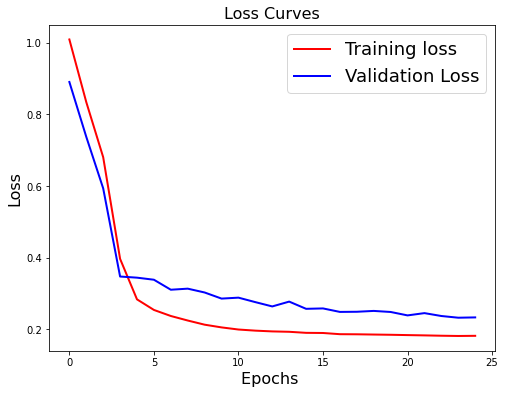

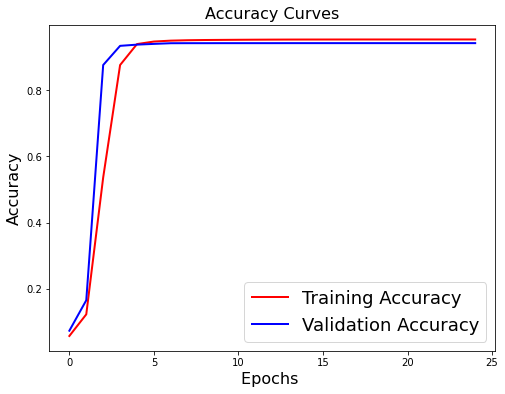

In [ ]:
#Accuracy graphs 
#Loss Curves
plt.figure(figsize=[8,6])
plt.plot(results_unet.history['loss'],'r',linewidth=2.0)
plt.plot(results_unet.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(results_unet.history['accuracy'],'r',linewidth=2.0)
plt.plot(results_unet.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### Prediction 

In [ ]:
idx = random.randint(0, len(X_train))

preds_train_unet = model_unet_original.predict(X_train, verbose=1)
preds_val_unet = model_unet_original.predict(X_train, verbose=1)
preds_test_unet = model_unet_original.predict(X_test, verbose=1)

 
preds_train_t = (preds_train_unet > 0.5)
preds_val_t = (preds_val_unet > 0.5)
preds_test_t = (preds_test_unet > 0.5)

1/1 [==============================] - 0s 23ms/step


In [ ]:
X_val = X_train[int(X_train.shape[0]*0.9):]
Y_val = Y_train[int(Y_train.shape[0]*0.9):]

In [ ]:
def bool_to_unit_img(image):
  image_new = image.astype(np.uint8)  #To convert the true to 1 and false to 0
  image_new*=255
  return image_new

**We can observe the predicted mask is not able to capture the masked portion on training set even after good training results**

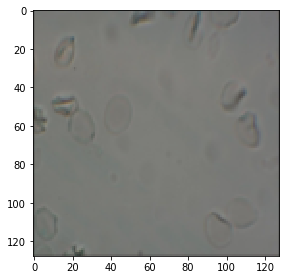

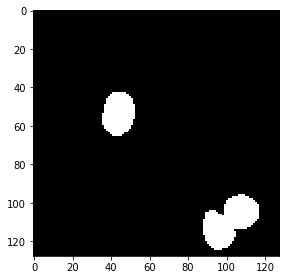

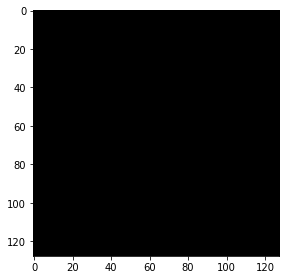

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(np.squeeze(X_train[ix]))
plt.show()
imshow(np.squeeze(bool_to_unit_img(Y_train[ix])))
plt.show()
imshow(np.squeeze(bool_to_unit_img(preds_train_t[ix])),cmap='gray')
plt.show()

## SEGMENTATION MODELS LIBRARY
* Reference : https://github.com/qubvel/segmentation_models 

- This library includes pre-defined functions such as jaccard loss and IoU(Intersection over Union) metric which are able to handle Data Imbalance and evaluate the model accurately, unlike tensorflow we dont have to define loss function seperately , it is readily available in the library.

- This segmenatation library provides many pre-trained backbones to train our network, this backbones are used in the encoder part of the architecture
- These backbones are trained on ImageNet dataset
- The advantage of using this library is we can use pre-trained weights and we dont have to train the model form scratch everytime and models converge faster


In [ ]:
!pip install segmentation_models

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

In [ ]:
#required step to type error while training
Y_train = tf.cast(Y_train,tf.float32)

### **ORIGINAL UNET MODEL**
* Here I am training the normal U-net model with loss function changed to bce jaccard loss and accuracy metric to mean IoU

* - Learning rate = 0.0001
  - batch size = 8
  - epochs = 200
  - train split = 0.8
  - validation split = 0.1
  - test split = 0.1

* The hyperparameters I used were working better comparatively while experimenting , In other models and backbones I am using the same parameters for fair comparison



In [ ]:
#Defining the model
model = sm.Unet(classes=1, activation='sigmoid')

#Compiling the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

#Fitting the data
results = model.fit(X_train,Y_train, validation_split=0.1, batch_size=8, epochs=200) 

Epoch 1/200
11/11 [==============================] - 3s 126ms/step - loss: 1.6059 - iou_score: 0.0496 - val_loss: 2.1444 - val_iou_score: 0.0549
Epoch 2/200
11/11 [==============================] - 1s 84ms/step - loss: 1.5146 - iou_score: 0.0528 - val_loss: 1.9574 - val_iou_score: 0.0555
Epoch 3/200
11/11 [==============================] - 1s 86ms/step - loss: 1.4597 - iou_score: 0.0536 - val_loss: 1.7094 - val_iou_score: 0.0533
Epoch 4/200
11/11 [==============================] - 1s 82ms/step - loss: 1.4229 - iou_score: 0.0554 - val_loss: 1.5865 - val_iou_score: 0.0535
Epoch 5/200
11/11 [==============================] - 1s 83ms/step - loss: 1.3940 - iou_score: 0.0583 - val_loss: 1.5279 - val_iou_score: 0.0531
Epoch 6/200
11/11 [==============================] - 1s 83ms/step - loss: 1.3682 - iou_score: 0.0617 - val_loss: 1.5267 - val_iou_score: 0.0532
Epoch 7/200
11/11 [==============================] - 1s 86ms/step - loss: 1.3458 - iou_score: 0.0649 - val_loss: 1.5201 - val_iou_score

#### Graphs - **ORIGINAL UNET MODEL**
Observations:
- Training loss is able to converge but validation loss is not able to converge even after increased epochs , It is constantly going in the range ,this is believed mainly due to limitation of our dataset and less complexity in it

- The difference between validation and training accuracy is also quite significant but the model learning has reached its limit , it is not able to learn more


Text(0.5, 1.0, 'Accuracy Curves')

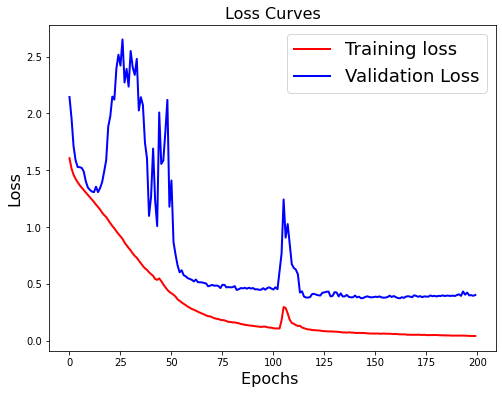

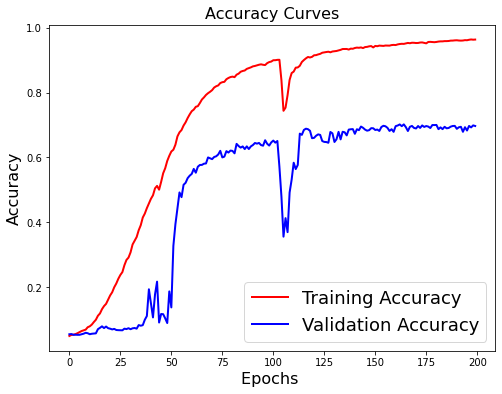

In [ ]:
#Accuracy graphs 

#Loss Curves
plt.figure(figsize=[8,6])
plt.plot(results.history['loss'],'r',linewidth=2.0)
plt.plot(results.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(results.history['iou_score'],'r',linewidth=2.0)
plt.plot(results.history['val_iou_score'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#### Prediction - **ORIGINAL UNET MODEL**
- The model is able to predict on test dataset regardless of training , But If we introduce some more complex images , Model may not be able to predict propely , because the train data we have used is having simple cells 


In [ ]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train>0.5).astype(np.uint8)
preds_val_t = (preds_val>0.5).astype(np.uint8)
preds_test_t = (preds_test>0.5).astype(np.uint8)

1/1 [==============================] - 0s 23ms/step


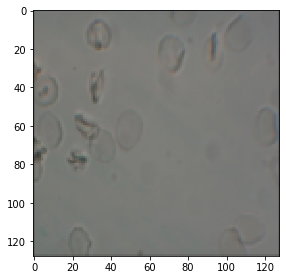

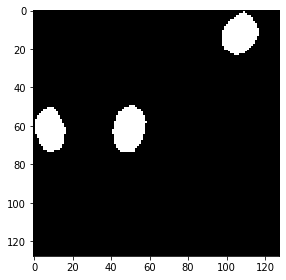

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


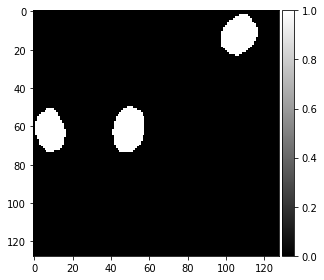

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]),cmap='gray')
plt.show()

**Prediction on the test dataset**
- While predicting , It is able to predict some of the target cells properly , but many of the cells it is not able to capture properly like the portion of the mask is not in proper orientation

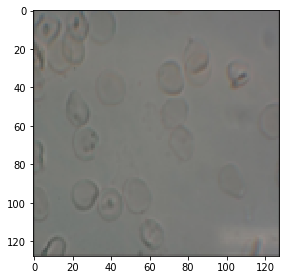

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


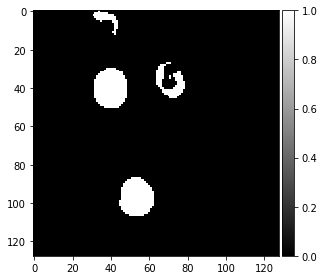

In [ ]:
# Perform a sanity check on some random test samples
ix = random.randint(0, len(preds_test_t))

imshow(np.squeeze(X_test[ix]))
plt.show()
imshow(np.squeeze(preds_test_t[ix]),cmap='gray')
plt.show()

### MOBILENET - Backbone with U-Net 
- This backbone has a similar structure to the encoder part of the Original U-net Architecture , but has pretrained weights with Image-net Dataset

- Parameters:
  - learning rate: 0.0001
  - batch size = 8
  - loss = bce_jaccard_loss
  - epochs = 200

In [ ]:
BACKBONE = 'mobilenet'

preprocess_input = sm.get_preprocessing(BACKBONE)
#X_train_1 = preprocess_input(X_train)
model1 = sm.Unet(BACKBONE, classes=1, activation='sigmoid',encoder_weights='imagenet')

/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [ ]:
model1.summary()

In [ ]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [ ]:
results1 = model1.fit(X_train,Y_train, validation_split=0.2, batch_size=8, epochs=200) #, callbacks=callbacks)

#### Graphs - MOBILENET - Backbone with U-Net 
Observations: 
* Compared to the original U-net architecture the model was learning faster as we had pretrained weights, but the validation dataset was performing poor in comparison.


Text(0.5, 1.0, 'Accuracy Curves')

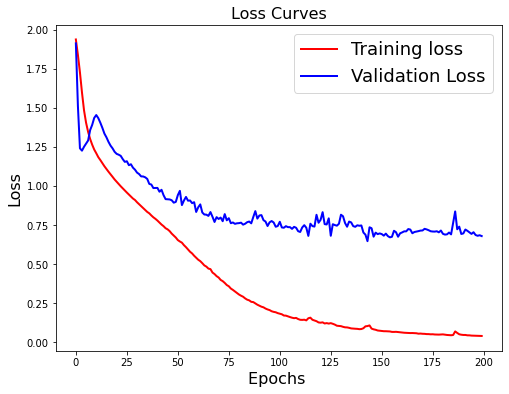

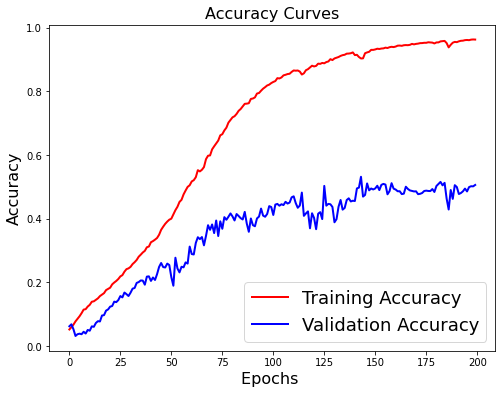

In [ ]:
#Accuracy graphs 

#Loss Curves
plt.figure(figsize=[8,6])
plt.plot(results1.history['loss'],'r',linewidth=2.0)
plt.plot(results1.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(results1.history['iou_score'],'r',linewidth=2.0)
plt.plot(results1.history['val_iou_score'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#### Prediction - MOBILENET - Backbone with U-Net 


In [ ]:
idx = random.randint(0, len(X_train))


preds_train = model1.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model1.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model1.predict(X_test, verbose=1)

 
preds_train_t = (preds_train>0.5).astype(np.uint8)
preds_val_t = (preds_val>0.5).astype(np.uint8)
preds_test_t = (preds_test>0.5).astype(np.uint8)

1/1 [==============================] - 0s 23ms/step


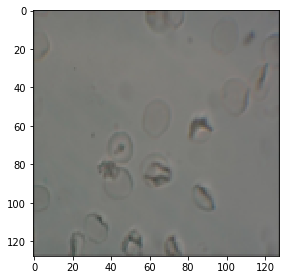

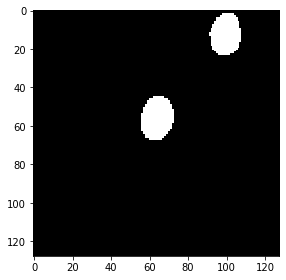

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


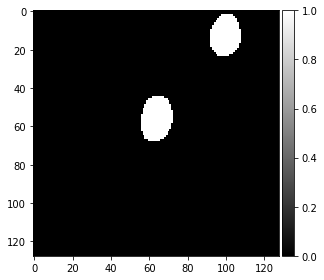

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]),cmap='gray')
plt.show()

**Prediction on the test dataset**
- Here the model is able to predict fairly, even though after poor training performance
- Although here in this test sample below ,One cell it's trying to capture in the bottom but the mask is incomplete and not able to predict accurately on that cell

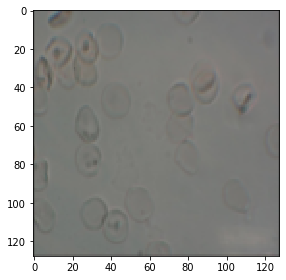

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


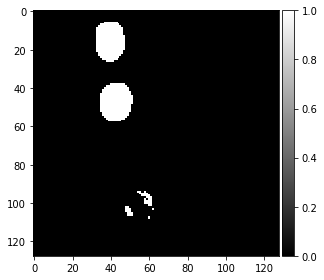

In [ ]:
#Sanity check on test samples
ix = random.randint(0, len(preds_test_t))

imshow(np.squeeze(X_test[ix]))
plt.show()
imshow(np.squeeze(preds_test_t[ix]),cmap='gray')
plt.show()

### Inceptionv3 - Backbone with U-Net
- **INCEPTION MODEL** : To avoid overfit  the inception models uses the idea of using multiple filters of different sizes on the same level. Thus in the inception models instead of having deep layers, we have parallel layers thus making our model wider rather than making it deeper
- I have used the architecture as backbone for U-net with same hyperparameters as above for experimentation


In [ ]:
BACKBONE = 'inceptionv3'
preprocess_input = sm.get_preprocessing(BACKBONE)

#Prprocess
#X_train_2 = preprocess_input(X_train)

#Model
model2 = sm.Unet(BACKBONE, classes=1, activation='sigmoid',encoder_weights='imagenet')

# model2.summary()

#Compiling the model
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

#fitting the data
results = model2.fit(X_train,Y_train, validation_split=0.1, batch_size=8, epochs=200)

87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/200
11/11 [==============================] - 36s 569ms/step - loss: 1.6546 - iou_score: 0.0495 - val_loss: 151.6283 - val_iou_score: 0.0568
Epoch 2/200
11/11 [==============================] - 1s 80ms/step - loss: 1.5783 - iou_score: 0.0561 - val_loss: 83.4270 - val_iou_score: 0.0570
Epoch 3/200
11/11 [==============================] - 1s 79ms/step - loss: 1.5182 - iou_score: 0.0607 - val_loss: 44.8404 - val_iou_score: 0.0577
Epoch 4/200
11/11 [==============================] - 1s 79ms/step - loss: 1.4651 - iou_score: 0.0701 - val_loss: 36.4690 - val_iou_score: 0.0578
Epoch 5/200
11/11 [==============================] - 1s 80ms/step - loss: 1.4136 - iou_score: 0.0781 - val_loss: 28.8466 - val_iou_score: 0.0576
Epoch 6/200
11/11 [==============================] - 1s 79ms/step - loss: 1.3640 - iou_score: 0.0909 - val_loss: 17.3760 - val_iou_score: 0.0577
Epoch 7/200
11/11 [==============================] - 1s 80ms/s

#### Graphs - Inceptionv3 - Backbone with U-Net
Observations:
- Here the loss is converging faster for both training and validatons, around 25-30 epochs
- Validation scores are constant after 70-80 epochs which is similar to the above models 

Text(0.5, 1.0, 'Accuracy Curves')

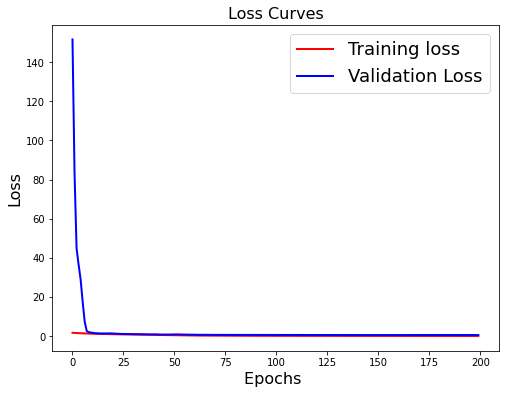

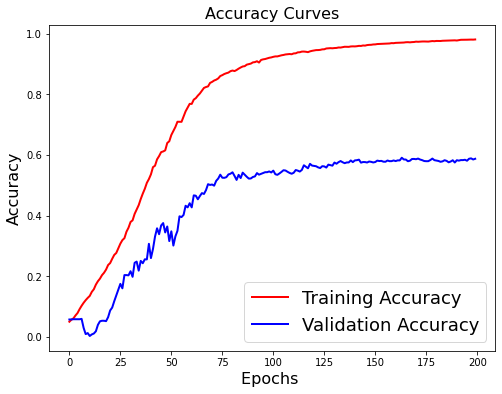

In [ ]:
#Accuracy graphs 

#Loss Curves
plt.figure(figsize=[8,6])
plt.plot(results.history['loss'],'r',linewidth=2.0)
plt.plot(results.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(results.history['iou_score'],'r',linewidth=2.0)
plt.plot(results.history['val_iou_score'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#### Prediction - Inceptionv3 - Backbone with U-Net

In [ ]:
idx = random.randint(0, len(X_train))


preds_train = model2.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model2.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model2.predict(X_test, verbose=1)

 
preds_train_t = (preds_train>0.5).astype(np.uint8)
preds_val_t = (preds_val>0.5).astype(np.uint8)
preds_test_t = (preds_test>0.5).astype(np.uint8)

1/1 [==============================] - 0s 25ms/step


In [ ]:
X_val = X_train[int(X_train.shape[0]*0.9):]
Y_val = Y_train[int(Y_train.shape[0]*0.9):]

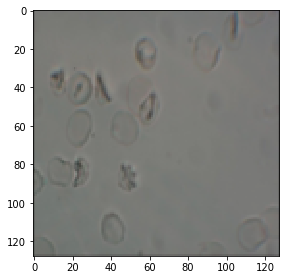

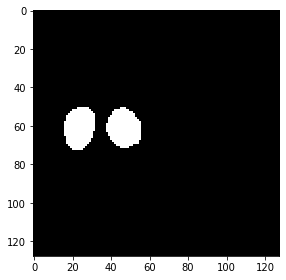

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


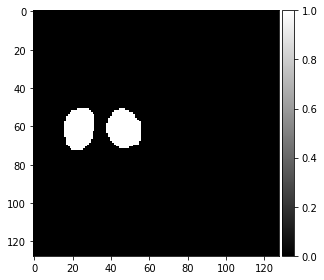

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]),cmap='gray')
plt.show()

**Prediction on Test Dataset**
- This model is able to capture all the portion of the mask properly, compared to model above where there were missing portions of the predicted masks


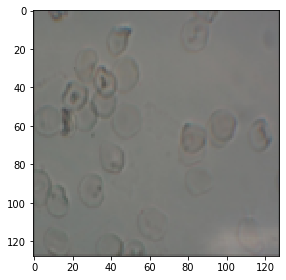

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


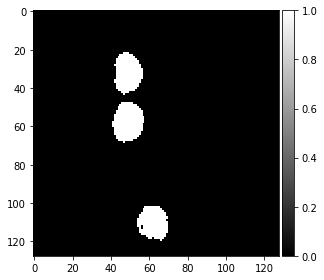

In [ ]:
#Sanity check on test samples
ix = random.randint(0, len(preds_test_t))

imshow(np.squeeze(X_test[ix]))
plt.show()
imshow(np.squeeze(preds_test_t[ix]),cmap='gray')
plt.show()

### **FPN**

* A Feature Pyramid Network, or FPN, is a feature extractor that takes a single-scale image of an arbitrary size as input, and outputs proportionally sized feature maps at multiple levels, in a fully convolutional fashion. This process is independent of the backbone convolutional architectures.

* It is an Object Detection Model , I tried it for experimentation purpose with the same hyperparameters as the models above to check if any significant results we are able to achieve rather than U-net architecture


In [ ]:
#Defining the model
model3 = sm.FPN(classes=1, activation='sigmoid')

#Compiling the model
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

#Fitting the data
results = model3.fit(X_train,Y_train, validation_split=0.1, batch_size=8, epochs=100) 

Epoch 1/100
11/11 [==============================] - 8s 307ms/step - loss: 1.6610 - iou_score: 0.0706 - val_loss: 1.2851 - val_iou_score: 0.0414
Epoch 2/100
11/11 [==============================] - 1s 107ms/step - loss: 1.2038 - iou_score: 0.1145 - val_loss: 0.9219 - val_iou_score: 0.2544
Epoch 3/100
11/11 [==============================] - 1s 107ms/step - loss: 1.0080 - iou_score: 0.1880 - val_loss: 0.7797 - val_iou_score: 0.3566
Epoch 4/100
11/11 [==============================] - 1s 108ms/step - loss: 0.8972 - iou_score: 0.2518 - val_loss: 0.7208 - val_iou_score: 0.3863
Epoch 5/100
11/11 [==============================] - 1s 108ms/step - loss: 0.7985 - iou_score: 0.3083 - val_loss: 0.7040 - val_iou_score: 0.4096
Epoch 6/100
11/11 [==============================] - 1s 106ms/step - loss: 0.7222 - iou_score: 0.3674 - val_loss: 0.7177 - val_iou_score: 0.4074
Epoch 7/100
11/11 [==============================] - 1s 106ms/step - loss: 0.6579 - iou_score: 0.4230 - val_loss: 0.7730 - val_iou

#### Graphs - FPN

Text(0.5, 1.0, 'Accuracy Curves')

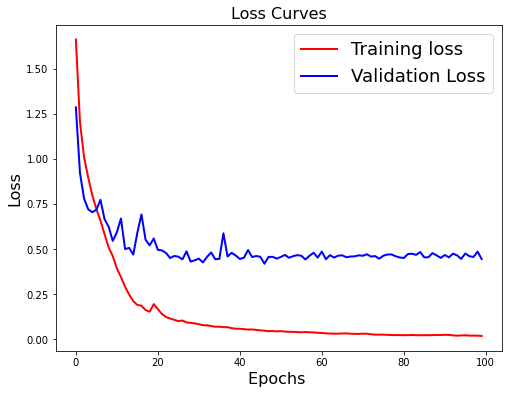

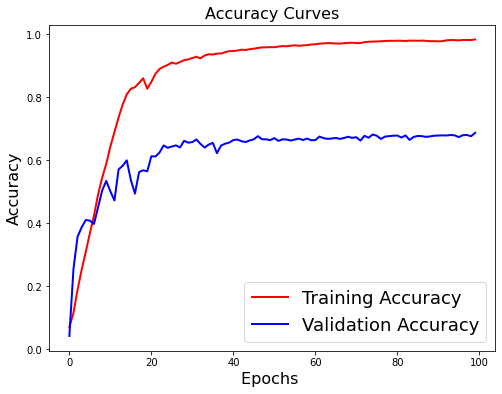

In [ ]:
#Accuracy graphs 

#Loss Curves
plt.figure(figsize=[8,6])
plt.plot(results.history['loss'],'r',linewidth=2.0)
plt.plot(results.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(results.history['iou_score'],'r',linewidth=2.0)
plt.plot(results.history['val_iou_score'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#### Prediction - FPN

In [ ]:
idx = random.randint(0, len(X_train))


preds_train = model3.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model3.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model3.predict(X_test, verbose=1)

 
preds_train_t = (preds_train>0.5).astype(np.uint8)
preds_val_t = (preds_val>0.5).astype(np.uint8)
preds_test_t = (preds_test>0.5).astype(np.uint8)

1/1 [==============================] - 0s 27ms/step


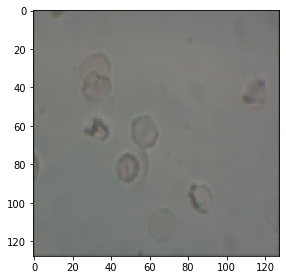

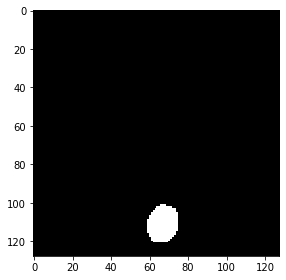

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


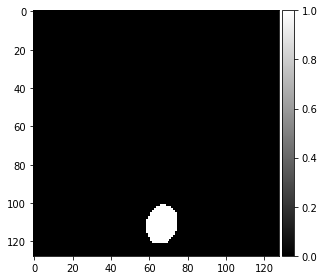

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]),cmap='gray')
plt.show()

**Here we can see it is not able to pick up any mask from the test Image Perfectly, As it is an object detection model , It is expected to not work on pixels in detail**

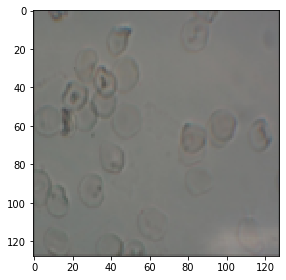

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


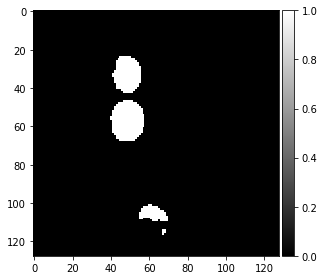

In [ ]:
#Sanity check on test samples
ix = random.randint(0, len(preds_test_t))

imshow(np.squeeze(X_test[ix]))
plt.show()
imshow(np.squeeze(preds_test_t[ix]),cmap='gray')
plt.show()

## CONCLUSION

1. Experimented with normal U-net architechture resulted with excellent results, but then realised the loss function and metrics used were not suitable for the given problem , and on the test dataset model was not able to predict anything, just a black screen. 

2. Introducted Segmetantion Models Library, I used the Original Unet model with weighted binary cross ectropy and jaccard loss and IoU score as metric, Model was performing well, Although the loss and accuracy of the model was resulting in bottleneck, it was not able to learn after 125 epochs, As far as prediction part is concerned it was able to predict on test image with many of the target cells missing in the predicted mask

3. MOBILENET as backbone , the performance was simmilar to the normal U-net without backbone, the model here stopped converging after 150 epochs, But here the error rate was quite reduced as we had pretrained wieghts which helped in training , during prediction part , it is almost similar to the above model , not much difference was observed.

4. Inception v3 as backbone, the IoU score achieved was the highest among all the previous models, the loss converged very soon around 25-30 epochs, the predicted masks were also coming in proper shapes without any missing of the target cells in the predicted mask, This I found was the **Best Model** for current dataset

5. Feature Pyramid Network, I tried it as a model other than U-net to see if it give some significant results, Although it is an objection detection model, It was showing good performance while training, but in the test prediction it failing to pick the masks properly, so this model cannot be used for this particular task

6. These backbones used are of classification models but they are just used as encoder part of the network with advantage of pre-trained weights on ImageNet dataset which increases the speed of training ,the flow of the rest architecture is similar to the U-net segmentation model


## REFERENCES
 * Segmentation Library: https://github.com/qubvel/segmentation_models
 * Data Modelling and Base Unet Architectures: https://github.com/bnsreenu/python_for_microscopists

## EXTRA WORK

* I Implemeneted this to get an Idea for **Semantic Image Segmentation** by the code available on research blog (https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/ ) , The dataset used was oxford pet dataset which contained 37 categories with different breed of cats and dogs, The dataset had good comlexity , the model was converging and the predicted masks were coming almost similar to the test image, Although I observed some features were still missing , this problem maybe be solved by hyperparameter tunings or working more with the dataset

* Link to Colab: https://colab.research.google.com/drive/1L8xqBGISayV6yBdoeVJbQmWRiJ9PAWw3?usp=sharing